# HYBRID SEARCH ENGINE WITH RERANKING - COMPLETE IMPLEMENTATION
# BM25 + IndoBERT Embeddings + Cross-Encoder Reranking

In [2]:
# ============================================================================
# CELL 1: Import Libraries
# ============================================================================
import pandas as pd
import numpy as np
import re
import os
from collections import Counter

# NLP Libraries
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# BM25
from rank_bm25 import BM25Okapi

# Transformers & PyTorch
import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from tqdm import tqdm

# Sklearn
from sklearn.metrics.pairwise import cosine_similarity

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

print(f"✅ Libraries imported!")
print(f"PyTorch: {torch.__version__}, CUDA: {torch.cuda.is_available()}")

✅ Libraries imported!
PyTorch: 2.8.0+cu126, CUDA: True


In [3]:
# ============================================================================
# CELL 2: Load Dataset
# ============================================================================
df_combine = pd.read_csv('combined_nutrisi_dataset.csv', sep=';', 
                         quotechar='"', encoding='utf-8')
print(f"✅ Data loaded! Total articles: {len(df_combine)}")

✅ Data loaded! Total articles: 1539


In [4]:

# ============================================================================
# CELL 3: Text Preprocessor
# ============================================================================
class TextPreprocessor:
    def __init__(self):
        self.stemmer = StemmerFactory().create_stemmer()
        self.stopword_remover = StopWordRemoverFactory().create_stop_word_remover()
        
    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    
    def preprocess_for_bm25(self, text):
        text = self.clean_text(text)
        text = self.stopword_remover.remove(text)
        text = self.stemmer.stem(text)
        return text.split()
    
    def preprocess_for_embedding(self, text):
        return self.clean_text(text)

preprocessor = TextPreprocessor()
print("✅ Preprocessor ready!")

✅ Preprocessor ready!


In [5]:
# ============================================================================
# CELL 4: IndoBERT Embedder
# ============================================================================
class IndoBERTEmbedder:
    def __init__(self, model_name='indobenchmark/indobert-base-p1'):
        print(f"Loading IndoBERT: {model_name}")
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(self.device)
        self.model.eval()
        print("✅ IndoBERT loaded!")
    
    def mean_pooling(self, model_output, attention_mask):
        token_emb = model_output[0]
        mask_expanded = attention_mask.unsqueeze(-1).expand(token_emb.size()).float()
        return torch.sum(token_emb * mask_expanded, 1) / torch.clamp(mask_expanded.sum(1), min=1e-9)
    
    def encode(self, texts, batch_size=16, show_progress=True):
        if isinstance(texts, str):
            texts = [texts]
        
        all_emb = []
        iterator = range(0, len(texts), batch_size)
        if show_progress:
            iterator = tqdm(iterator, desc="Encoding")
        
        with torch.no_grad():
            for i in iterator:
                batch = texts[i:i + batch_size]
                enc = self.tokenizer(batch, padding=True, truncation=True, 
                                    max_length=512, return_tensors='pt').to(self.device)
                output = self.model(**enc)
                emb = self.mean_pooling(output, enc['attention_mask'])
                emb = torch.nn.functional.normalize(emb, p=2, dim=1)
                all_emb.append(emb.cpu().numpy())
        
        return np.vstack(all_emb)

embedder = IndoBERTEmbedder()

Loading IndoBERT: indobenchmark/indobert-base-p1
✅ IndoBERT loaded!


In [7]:
# ============================================================================
# CELL 5: Cross-Encoder Reranker
# ============================================================================
class CrossEncoderReranker:
    """
    Cross-Encoder using IndoBERT to compute query-document similarity.
    Since no pre-trained cross-encoder is available, we use bi-encoder
    in cross-encoder mode by concatenating query and document.
    """
    def __init__(self, model_name='indobenchmark/indobert-base-p1'):
        print(f"Loading Cross-Encoder (IndoBERT-based): {model_name}")
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(self.device)
        self.model.eval()
        print("✅ Cross-Encoder loaded!")
    
    def mean_pooling(self, model_output, attention_mask):
        token_emb = model_output[0]
        mask_expanded = attention_mask.unsqueeze(-1).expand(token_emb.size()).float()
        return torch.sum(token_emb * mask_expanded, 1) / torch.clamp(mask_expanded.sum(1), min=1e-9)
    
    def predict(self, query, documents, batch_size=8):
        """
        Compute relevance scores by encoding query+doc concatenation
        and measuring similarity with query embedding
        """
        scores = []
        
        # Encode query separately for reference
        with torch.no_grad():
            query_enc = self.tokenizer([query], padding=True, truncation=True, 
                                      max_length=128, return_tensors='pt').to(self.device)
            query_output = self.model(**query_enc)
            query_emb = self.mean_pooling(query_output, query_enc['attention_mask'])
            query_emb = torch.nn.functional.normalize(query_emb, p=2, dim=1)
            
            # Process documents in batches
            for i in range(0, len(documents), batch_size):
                batch_docs = documents[i:i + batch_size]
                
                # Create query-document pairs with separator
                pairs = [f"{query} [SEP] {doc[:400]}" for doc in batch_docs]
                
                enc = self.tokenizer(pairs, padding=True, truncation=True, 
                                    max_length=512, return_tensors='pt').to(self.device)
                
                outputs = self.model(**enc)
                doc_embs = self.mean_pooling(outputs, enc['attention_mask'])
                doc_embs = torch.nn.functional.normalize(doc_embs, p=2, dim=1)
                
                # Compute similarity scores
                batch_scores = torch.mm(query_emb, doc_embs.T).squeeze(0).cpu().numpy()
                
                if isinstance(batch_scores, np.ndarray) and batch_scores.ndim == 0:
                    batch_scores = [float(batch_scores)]
                
                scores.extend(batch_scores)
        
        return np.array(scores)

reranker = CrossEncoderReranker()


Loading Cross-Encoder (IndoBERT-based): indobenchmark/indobert-base-p1
✅ Cross-Encoder loaded!


In [8]:
# ============================================================================
# CELL 6: Build BM25 Index
# ============================================================================
print("Building BM25 index...")
documents_text = (df_combine['Judul'] + ' ' + df_combine['Konten']).tolist()
tokenized_corpus = [preprocessor.preprocess_for_bm25(doc) 
                    for doc in tqdm(documents_text, desc="Tokenizing")]
bm25 = BM25Okapi(tokenized_corpus)
print(f"✅ BM25 index built! {len(tokenized_corpus)} documents")

Building BM25 index...


Tokenizing: 100%|██████████████████████████████████████████████████████████████████| 1539/1539 [17:02<00:00,  1.51it/s]


✅ BM25 index built! 1539 documents


In [9]:
# ============================================================================
# CELL 7: Generate/Load Embeddings
# ============================================================================
embedding_file = 'document_embeddings_indobert.npy'

if os.path.exists(embedding_file):
    print("Loading embeddings...")
    document_embeddings = np.load(embedding_file)
    print(f"✅ Embeddings loaded! Shape: {document_embeddings.shape}")
else:
    print("Generating embeddings...")
    docs_clean = [preprocessor.preprocess_for_embedding(row['Judul'] + ' ' + row['Konten']) 
                  for _, row in tqdm(df_combine.iterrows(), total=len(df_combine))]
    document_embeddings = embedder.encode(docs_clean, batch_size=16)
    np.save(embedding_file, document_embeddings)
    print(f"✅ Embeddings saved! Shape: {document_embeddings.shape}")

Loading embeddings...
✅ Embeddings loaded! Shape: (1539, 768)


In [10]:
# ============================================================================
# CELL 8: Hybrid Search Engine
# ============================================================================
class HybridSearchEngine:
    def __init__(self, bm25_index, embedder, doc_embeddings, reranker, df, preprocessor):
        self.bm25 = bm25_index
        self.embedder = embedder
        self.doc_embeddings = doc_embeddings
        self.reranker = reranker
        self.df = df
        self.preprocessor = preprocessor
    
    def search(self, query, top_k=5, candidate_pool=50, 
               bm25_weight=0.3, emb_weight=0.7, use_reranking=True):
        # 1. BM25 scores
        query_tokens = self.preprocessor.preprocess_for_bm25(query)
        bm25_scores = self.bm25.get_scores(query_tokens)
        bm25_scores = (bm25_scores - bm25_scores.min()) / (bm25_scores.max() - bm25_scores.min() + 1e-9)
        
        # 2. Embedding scores
        query_clean = self.preprocessor.preprocess_for_embedding(query)
        query_emb = self.embedder.encode([query_clean], show_progress=False)
        emb_scores = cosine_similarity(query_emb, self.doc_embeddings).flatten()
        
        # 3. Hybrid scores
        hybrid_scores = (bm25_weight * bm25_scores) + (emb_weight * emb_scores)
        top_indices = hybrid_scores.argsort()[-candidate_pool:][::-1]
        
        # 4. Reranking
        if use_reranking:
            candidate_docs = []
            for idx in top_indices:
                doc_text = self.df.iloc[idx]['Judul'] + ' ' + self.df.iloc[idx]['Konten']
                doc_text = self.preprocessor.preprocess_for_embedding(doc_text)[:512]
                candidate_docs.append(doc_text)
            
            rerank_scores = self.reranker.predict(query_clean, candidate_docs)
            
            final_scores = []
            for i, idx in enumerate(top_indices):
                combined = (0.5 * hybrid_scores[idx]) + (0.5 * rerank_scores[i])
                final_scores.append((idx, combined, hybrid_scores[idx], rerank_scores[i]))
            
            final_scores.sort(key=lambda x: x[1], reverse=True)
            top_results = final_scores[:top_k]
        else:
            top_results = [(idx, hybrid_scores[idx], hybrid_scores[idx], 0) 
                          for idx in top_indices[:top_k]]
        
        # Format results
        results = []
        for rank, (idx, final_score, hybrid_score, rerank_score) in enumerate(top_results, 1):
            results.append({
                'rank': rank,
                'doc_id': int(idx),
                'title': self.df.iloc[idx]['Judul'],
                'url': self.df.iloc[idx]['URL'],
                'final_score': float(final_score),
                'hybrid_score': float(hybrid_score),
                'rerank_score': float(rerank_score),
                'bm25_score': float(bm25_scores[idx]),
                'emb_score': float(emb_scores[idx]),
                'snippet': self.df.iloc[idx]['Konten'][:200] + '...'
            })
        
        return {'query': query, 'results': results, 'reranking_used': use_reranking}

hybrid_engine = HybridSearchEngine(bm25, embedder, document_embeddings, 
                                   reranker, df_combine, preprocessor)
print("✅ Hybrid Search Engine ready!")

✅ Hybrid Search Engine ready!


In [26]:
# ============================================================================
# CELL 9: Test Search
# ============================================================================
print("\n" + "="*80)
print("TESTING HYBRID SEARCH")
print("="*80)

test_query = "Menu diet seminggu untuk turun 5 kg"
print(f"\nQuery: {test_query}\n")

result = hybrid_engine.search(test_query, top_k=5, use_reranking=True)

for r in result['results']:
    print(f"{r['rank']}. [{r['final_score']:.3f}] {r['title']}")
    print(f"   BM25: {r['bm25_score']:.3f} | Emb: {r['emb_score']:.3f} | Rerank: {r['rerank_score']:.3f}\n")


TESTING HYBRID SEARCH

Query: Menu diet seminggu untuk turun 5 kg

1. [0.717] Diet Seminggu untuk Turun 10 Kg Berbahaya, Ini Alternatifnya
   BM25: 1.000 | Emb: 0.540 | Rerank: 0.756

2. [0.677] Berapa Kg Berat Badan yang Boleh Turun dalam Seminggu?
   BM25: 0.852 | Emb: 0.536 | Rerank: 0.723

3. [0.643] 7 Cara Diet Sehat agar Tubuh Ideal dan Tetap Bugar
   BM25: 0.707 | Emb: 0.516 | Rerank: 0.712

4. [0.637] Rekomendasi Menu Diet Sehat 30 Hari, Mudah dan Praktis
   BM25: 0.718 | Emb: 0.477 | Rerank: 0.725

5. [0.637] Menu Diet Mayo untuk Mendapatkan Tubuh Sehat dan Ideal
   BM25: 0.908 | Emb: 0.482 | Rerank: 0.664



In [12]:
# ============================================================================
# CELL 10: Evaluation Queries
# ============================================================================
EVAL_QUERIES = [
    {'query': 'Menu diet seminggu untuk turun 5 kg', 
     'relevant_docs': [575, 244, 279, 39, 86]},
    {'query': 'Vitamin penambah nafsu makan untuk balita', 
     'relevant_docs': [610, 250, 494, 275, 1211]},
    {'query': 'Makanan pelancar ASI alami dan enak', 
     'relevant_docs': [890, 96, 724, 1285, 314]},
    {'query': 'Resep jus detoks untuk membersihkan usus', 
     'relevant_docs': [111, 543, 1376, 160, 291]},
    {'query': 'Makanan tinggi protein murah untuk anak gym', 
     'relevant_docs': [1273, 527, 964, 323, 1101]},
    {'query': 'Pengganti nasi putih untuk penderita diabetes', 
     'relevant_docs': [759, 304, 716, 1222, 1206]},
    {'query': 'Makanan yang mengandung kolagen alami tinggi', 
     'relevant_docs': [995, 1423, 1012, 1273, 657]},
    {'query': 'Teknik memasak sayur agar vitamin tidak hilang', 
     'relevant_docs': [49, 223, 20, 18, 583]},
]

print(f"✅ {len(EVAL_QUERIES)} evaluation queries prepared")

✅ 8 evaluation queries prepared


In [13]:
# ============================================================================
# CELL 11: Evaluator
# ============================================================================
class Evaluator:
    def __init__(self, engine):
        self.engine = engine
    
    def precision_at_k(self, retrieved, relevant, k):
        retrieved_k = retrieved[:k]
        return len(set(retrieved_k) & set(relevant)) / k if k > 0 else 0
    
    def recall_at_k(self, retrieved, relevant, k):
        retrieved_k = retrieved[:k]
        return len(set(retrieved_k) & set(relevant)) / len(relevant) if len(relevant) > 0 else 0
    
    def f1_score(self, p, r):
        return 2 * (p * r) / (p + r) if (p + r) > 0 else 0
    
    def average_precision(self, retrieved, relevant):
        if len(relevant) == 0:
            return 0
        p_sum, rel_count = 0, 0
        for k, doc_id in enumerate(retrieved, 1):
            if doc_id in relevant:
                rel_count += 1
                p_sum += rel_count / k
        return p_sum / len(relevant)
    
    def mrr(self, retrieved, relevant):
        for i, doc_id in enumerate(retrieved, 1):
            if doc_id in relevant:
                return 1.0 / i
        return 0.0
    
    def ndcg_at_k(self, retrieved, relevant, k):
        dcg = sum(1 / np.log2(i + 1) for i, doc_id in enumerate(retrieved[:k], 1) 
                  if doc_id in relevant)
        idcg = sum(1 / np.log2(i + 1) for i in range(1, min(len(relevant), k) + 1))
        return dcg / idcg if idcg > 0 else 0
    
    def evaluate(self, eval_queries, k_values=[1, 3, 5, 10], use_reranking=True):
        results = {
            'queries': [],
            'precision': {f'P@{k}': [] for k in k_values},
            'recall': {f'R@{k}': [] for k in k_values},
            'f1': {f'F1@{k}': [] for k in k_values},
            'ndcg': {f'NDCG@{k}': [] for k in k_values},
            'ap': [], 'mrr': []
        }
        
        for eq in tqdm(eval_queries, desc="Evaluating"):
            query = eq['query']
            relevant = eq['relevant_docs']
            
            search_result = self.engine.search(query, top_k=max(k_values), 
                                              use_reranking=use_reranking)
            retrieved = [r['doc_id'] for r in search_result['results']]
            
            qm = {'query': query}
            for k in k_values:
                p = self.precision_at_k(retrieved, relevant, k)
                r = self.recall_at_k(retrieved, relevant, k)
                f1 = self.f1_score(p, r)
                ndcg = self.ndcg_at_k(retrieved, relevant, k)
                
                results['precision'][f'P@{k}'].append(p)
                results['recall'][f'R@{k}'].append(r)
                results['f1'][f'F1@{k}'].append(f1)
                results['ndcg'][f'NDCG@{k}'].append(ndcg)
                
                qm.update({f'P@{k}': p, f'R@{k}': r, f'F1@{k}': f1, f'NDCG@{k}': ndcg})
            
            ap = self.average_precision(retrieved, relevant)
            mrr = self.mrr(retrieved, relevant)
            results['ap'].append(ap)
            results['mrr'].append(mrr)
            qm.update({'AP': ap, 'MRR': mrr})
            
            results['queries'].append(qm)
        
        results['mean'] = {
            **{k: np.mean(v) for k, v in results['precision'].items()},
            **{k: np.mean(v) for k, v in results['recall'].items()},
            **{k: np.mean(v) for k, v in results['f1'].items()},
            **{k: np.mean(v) for k, v in results['ndcg'].items()},
            'MAP': np.mean(results['ap']),
            'MRR': np.mean(results['mrr'])
        }
        
        return results

evaluator = Evaluator(hybrid_engine)
print("✅ Evaluator ready!")

✅ Evaluator ready!


In [14]:
# ============================================================================
# CELL 12: Run Evaluation
# ============================================================================
print("\n" + "="*80)
print("RUNNING EVALUATION")
print("="*80)

print("\n📊 WITHOUT Reranking...")
results_without = evaluator.evaluate(EVAL_QUERIES, use_reranking=False)

print("\n📊 WITH Reranking...")
results_with = evaluator.evaluate(EVAL_QUERIES, use_reranking=True)

print("\n✅ Evaluation complete!")


RUNNING EVALUATION

📊 WITHOUT Reranking...


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 13.50it/s]



📊 WITH Reranking...


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.89it/s]


✅ Evaluation complete!


In [15]:
# ============================================================================
# CELL 13: Display Results
# ============================================================================
def print_results(results, title):
    print("\n" + "="*80)
    print(title)
    print("="*80)
    print("\nMean Metrics:")
    print("-" * 60)
    for metric, value in results['mean'].items():
        print(f"{metric:15s}: {value:.4f} ({value*100:.2f}%)")

print_results(results_without, "RESULTS WITHOUT RERANKING")
print_results(results_with, "RESULTS WITH RERANKING")

# Comparison
print("\n" + "="*80)
print("IMPROVEMENT WITH RERANKING")
print("="*80)
print("\nMetric Improvements:")
print("-" * 60)

for metric in ['P@5', 'R@5', 'F1@5', 'NDCG@5', 'MAP', 'MRR']:
    without = results_without['mean'][metric]
    with_r = results_with['mean'][metric]
    improvement = ((with_r - without) / without * 100) if without > 0 else 0
    print(f"{metric:15s}: {without:.4f} → {with_r:.4f} ({improvement:+.2f}%)")


RESULTS WITHOUT RERANKING

Mean Metrics:
------------------------------------------------------------
P@1            : 0.6250 (62.50%)
P@3            : 0.5417 (54.17%)
P@5            : 0.4500 (45.00%)
P@10           : 0.2375 (23.75%)
R@1            : 0.1250 (12.50%)
R@3            : 0.3250 (32.50%)
R@5            : 0.4500 (45.00%)
R@10           : 0.4750 (47.50%)
F1@1           : 0.2083 (20.83%)
F1@3           : 0.4062 (40.62%)
F1@5           : 0.4500 (45.00%)
F1@10          : 0.3167 (31.67%)
NDCG@1         : 0.6250 (62.50%)
NDCG@3         : 0.5817 (58.17%)
NDCG@5         : 0.5061 (50.61%)
NDCG@10        : 0.5195 (51.95%)
MAP            : 0.3744 (37.44%)
MRR            : 0.8125 (81.25%)

RESULTS WITH RERANKING

Mean Metrics:
------------------------------------------------------------
P@1            : 0.7500 (75.00%)
P@3            : 0.4167 (41.67%)
P@5            : 0.3500 (35.00%)
P@10           : 0.2625 (26.25%)
R@1            : 0.1500 (15.00%)
R@3            : 0.2500 (25.00%)
R@5  


✅ Visualization saved as 'hybrid_search_evaluation.png'


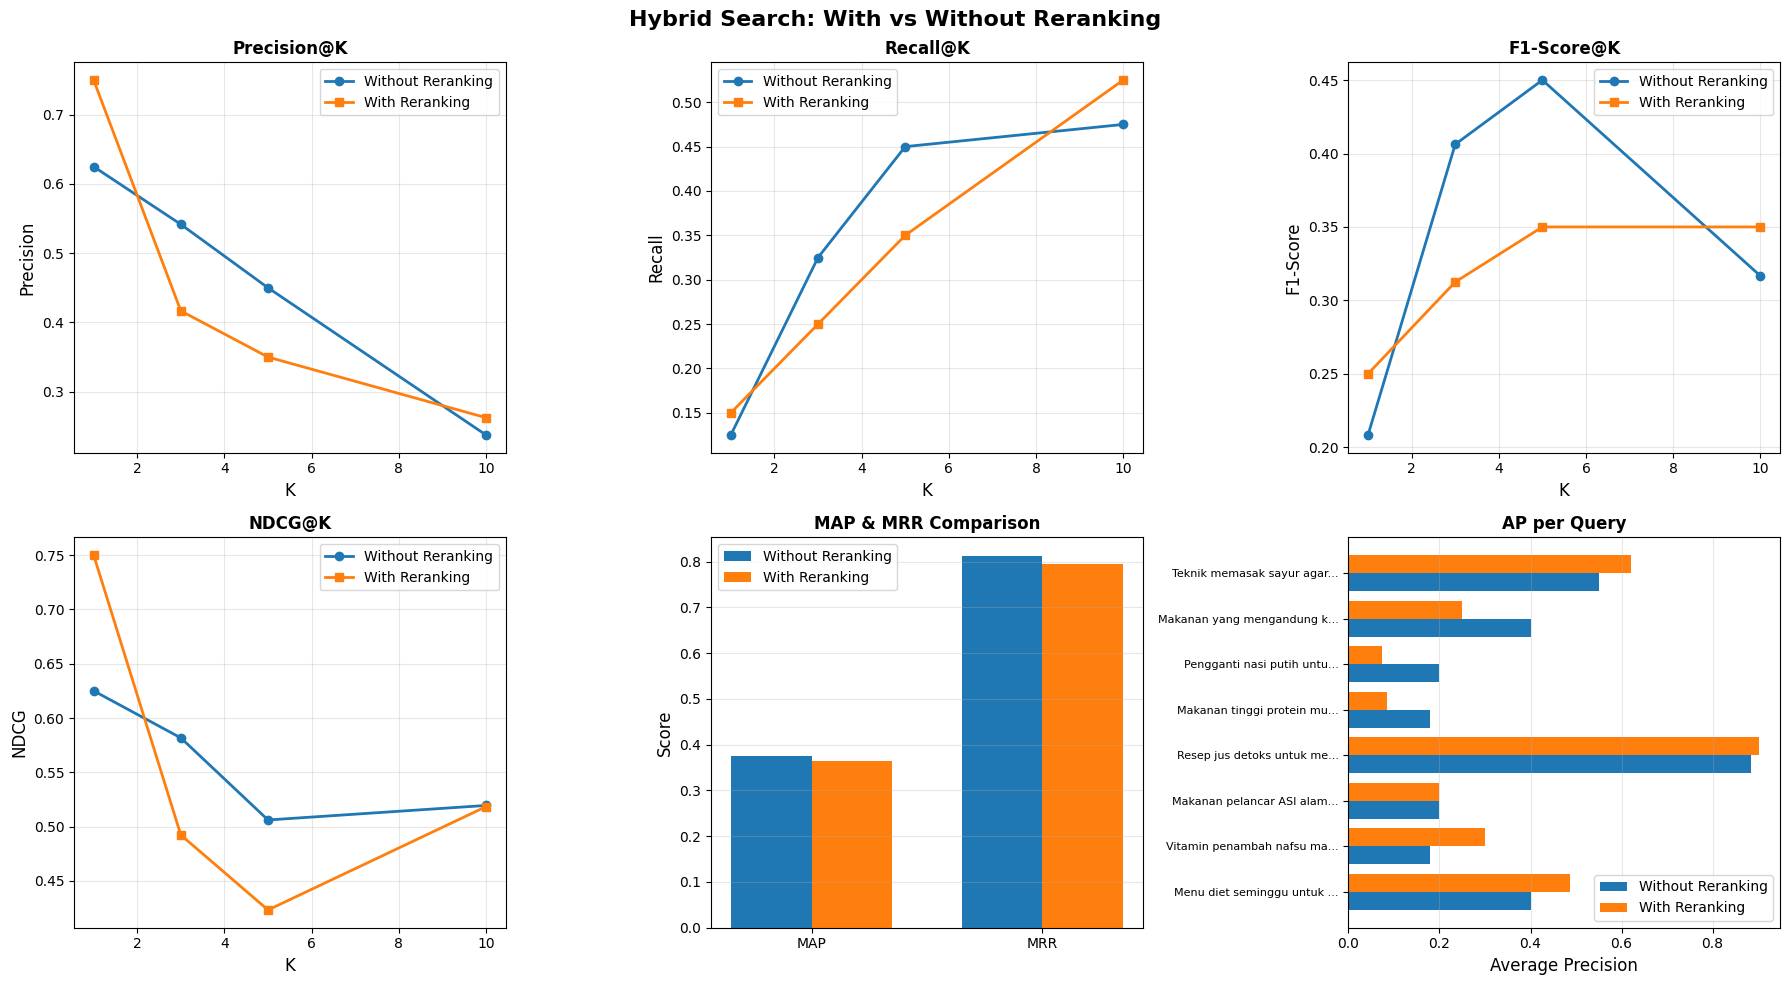

In [24]:
# ============================================================================
# CELL 14: Visualization
# ============================================================================
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Hybrid Search: With vs Without Reranking', fontsize=16, fontweight='bold')

k_values = [1, 3, 5, 10]

# Precision
p_without = [results_without['mean'][f'P@{k}'] for k in k_values]
p_with = [results_with['mean'][f'P@{k}'] for k in k_values]
axes[0, 0].plot(k_values, p_without, marker='o', label='Without Reranking', linewidth=2)
axes[0, 0].plot(k_values, p_with, marker='s', label='With Reranking', linewidth=2)
axes[0, 0].set_xlabel('K', fontsize=12)
axes[0, 0].set_ylabel('Precision', fontsize=12)
axes[0, 0].set_title('Precision@K', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Recall
r_without = [results_without['mean'][f'R@{k}'] for k in k_values]
r_with = [results_with['mean'][f'R@{k}'] for k in k_values]
axes[0, 1].plot(k_values, r_without, marker='o', label='Without Reranking', linewidth=2)
axes[0, 1].plot(k_values, r_with, marker='s', label='With Reranking', linewidth=2)
axes[0, 1].set_xlabel('K', fontsize=12)
axes[0, 1].set_ylabel('Recall', fontsize=12)
axes[0, 1].set_title('Recall@K', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# F1-Score
f1_without = [results_without['mean'][f'F1@{k}'] for k in k_values]
f1_with = [results_with['mean'][f'F1@{k}'] for k in k_values]
axes[0, 2].plot(k_values, f1_without, marker='o', label='Without Reranking', linewidth=2)
axes[0, 2].plot(k_values, f1_with, marker='s', label='With Reranking', linewidth=2)
axes[0, 2].set_xlabel('K', fontsize=12)
axes[0, 2].set_ylabel('F1-Score', fontsize=12)
axes[0, 2].set_title('F1-Score@K', fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# NDCG
ndcg_without = [results_without['mean'][f'NDCG@{k}'] for k in k_values]
ndcg_with = [results_with['mean'][f'NDCG@{k}'] for k in k_values]
axes[1, 0].plot(k_values, ndcg_without, marker='o', label='Without Reranking', linewidth=2)
axes[1, 0].plot(k_values, ndcg_with, marker='s', label='With Reranking', linewidth=2)
axes[1, 0].set_xlabel('K', fontsize=12)
axes[1, 0].set_ylabel('NDCG', fontsize=12)
axes[1, 0].set_title('NDCG@K', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# MAP & MRR Comparison
metrics = ['MAP', 'MRR']
without_vals = [results_without['mean'][m] for m in metrics]
with_vals = [results_with['mean'][m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35
axes[1, 1].bar(x - width/2, without_vals, width, label='Without Reranking')
axes[1, 1].bar(x + width/2, with_vals, width, label='With Reranking')
axes[1, 1].set_ylabel('Score', fontsize=12)
axes[1, 1].set_title('MAP & MRR Comparison', fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metrics)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Per-query AP
queries_short = [q['query'][:25] + '...' for q in results_with['queries']]
ap_without = [q['AP'] for q in results_without['queries']]
ap_with = [q['AP'] for q in results_with['queries']]

x = np.arange(len(queries_short))
axes[1, 2].barh(x - 0.2, ap_without, 0.4, label='Without Reranking')
axes[1, 2].barh(x + 0.2, ap_with, 0.4, label='With Reranking')
axes[1, 2].set_yticks(x)
axes[1, 2].set_yticklabels(queries_short, fontsize=8)
axes[1, 2].set_xlabel('Average Precision', fontsize=12)
axes[1, 2].set_title('AP per Query', fontweight='bold')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('hybrid_search_evaluation.png', dpi=300, bbox_inches='tight')
print("\n✅ Visualization saved as 'hybrid_search_evaluation.png'")
plt.show()

In [27]:
# ============================================================================
# CELL 15: Summary Report
# ============================================================================
print("\n" + "="*80)
print("FINAL SUMMARY REPORT")
print("="*80)

print(f"""
📊 OVERALL PERFORMANCE
{'='*60}

WITHOUT RERANKING:
  Precision@5: {results_without['mean']['P@5']:.2%}
  Recall@5:    {results_without['mean']['R@5']:.2%}
  F1@5:        {results_without['mean']['F1@5']:.2%}
  NDCG@5:      {results_without['mean']['NDCG@5']:.2%}
  MAP:         {results_without['mean']['MAP']:.2%}
  MRR:         {results_without['mean']['MRR']:.2%}

WITH RERANKING:
  Precision@5: {results_with['mean']['P@5']:.2%}
  Recall@5:    {results_with['mean']['R@5']:.2%}
  F1@5:        {results_with['mean']['F1@5']:.2%}
  NDCG@5:      {results_with['mean']['NDCG@5']:.2%}
  MAP:         {results_with['mean']['MAP']:.2%}
  MRR:         {results_with['mean']['MRR']:.2%}

{'='*60}

🎯 KEY FINDINGS:
""")

# Calculate improvements
for metric in ['P@5', 'R@5', 'F1@5', 'NDCG@5', 'MAP', 'MRR']:
    w = results_without['mean'][metric]
    r = results_with['mean'][metric]
    imp = ((r - w) / w * 100) if w > 0 else 0
    status = "📈" if imp > 0 else "📉" if imp < 0 else "➡️"
    print(f"{status} {metric}: {imp:+.2f}% improvement")

print(f"\n{'='*60}")

# Best queries
sorted_queries = sorted(results_with['queries'], key=lambda x: x['AP'], reverse=True)
print("\n🏆 TOP 3 PERFORMING QUERIES:")
for i, q in enumerate(sorted_queries[:3], 1):
    print(f"{i}. {q['query']}")
    print(f"   AP: {q['AP']:.2%}, P@5: {q['P@5']:.2%}, NDCG@5: {q['NDCG@5']:.2%}")

print("\n" + "="*80)
print("✅ EVALUATION COMPLETE!")
print("="*80)


FINAL SUMMARY REPORT

📊 OVERALL PERFORMANCE

WITHOUT RERANKING:
  Precision@5: 45.00%
  Recall@5:    45.00%
  F1@5:        45.00%
  NDCG@5:      50.61%
  MAP:         37.44%
  MRR:         81.25%

WITH RERANKING:
  Precision@5: 35.00%
  Recall@5:    35.00%
  F1@5:        35.00%
  NDCG@5:      42.33%
  MAP:         36.45%
  MRR:         79.58%


🎯 KEY FINDINGS:

📉 P@5: -22.22% improvement
📉 R@5: -22.22% improvement
📉 F1@5: -22.22% improvement
📉 NDCG@5: -16.37% improvement
📉 MAP: -2.63% improvement
📉 MRR: -2.05% improvement


🏆 TOP 3 PERFORMING QUERIES:
1. Resep jus detoks untuk membersihkan usus
   AP: 90.29%, P@5: 80.00%, NDCG@5: 85.39%
2. Teknik memasak sayur agar vitamin tidak hilang
   AP: 62.00%, P@5: 60.00%, NDCG@5: 68.44%
3. Menu diet seminggu untuk turun 5 kg
   AP: 48.57%, P@5: 40.00%, NDCG@5: 55.31%

✅ EVALUATION COMPLETE!
